In [1]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import string_interpolate

lowerModel =load_model('Model/devanagari_lowerMod_model.h5')
coreModel = load_model('Model/backup_last_model.hdf5')
upperModel = load_model('Model/devanagari_upperMod_model.h5')
lower_modifiers = [0x941,0x942, 0x943,0x094D] 

def Split(Words):
    Characters = []

    for Word in Words:
        gray = cv2.cvtColor(Word, cv2.COLOR_BGR2GRAY)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
        morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

        for i in range(morph.shape[0]):
            for j in range(morph.shape[1]):
                if not morph[i][j]:
                    morph[i][j] = 1

        div = gray / morph
        gray = np.array(cv2.normalize(
            div, div, 0, 255, cv2.NORM_MINMAX), np.uint8)

        _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)


        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        thresh = cv2.morphologyEx(
            thresh, cv2.MORPH_DILATE, kernel, iterations=1)
        plt.imshow(thresh,cmap='gray')
        plt.show()
        
        original_thresh = thresh.copy()

        h_proj = np.sum(thresh, axis=1)
        print(len(h_proj))
        Max = np.max(h_proj)/1.1
        print(Max)

        upper = None
        lower = None
        for i in range(h_proj.shape[0]):
            proj = h_proj[i]
            

            if proj > Max and upper == None:
                upper = i
            elif proj < Max and upper != None and lower == None:
                lower = i
                break
        print(upper, lower)

        if thresh.shape[1] > 100:
            for row in range(upper-7 if upper>7 else upper,lower+7):
                thresh[row] = 0
        plt.imshow(thresh,cmap='gray')
        plt.show()
        base = identify_lower_baseline(thresh)
        print("lower",base)
        
        segments=character_segmentation(thresh)
        word = ''
        for simg in segments[0]:
            plt.imshow(simg)
            plt.show()
            seg = modifier_segmentation(simg,base)
            word += seg
        print(word) 

    return Characters

def character_segmentation(bordered, thresh=255, min_seg=5, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        bg = np.repeat(255, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).any()):
                bg_keys.append(row) 
        print(bg_keys)

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        print(new_keys)
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                new_keys.append(bg_keys[i+1])
                #print(i)

        new_keys = sorted(new_keys)
        print("helo there")
        print(new_keys)
        segmented_templates = []
        first = new_keys[0]
        bounding_boxes = []
        for i in range(1,len(new_keys)-1,2):
            segment = bordered.T[first:new_keys[i]]
            if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                print('here')
                segmented_templates.append(segment.T)
                bounding_boxes.append((first, new_keys[i]))
            first = new_keys[i+1]  
        last_segment = bordered.T[new_keys[-2]:]

        
        if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
            segmented_templates.append(last_segment.T)
            bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))

        return(segmented_templates, bounding_boxes)
    except:
        return [bordered, (0, bordered.shape[1])]
    

def modifier_segmentation(bordered,base, thresh=255, min_seg=5, scheck=0.15):
    try:
        print("try")
        shape = bordered.shape
        print(shape)
        check = int(scheck * shape[1])
        checkhor = int(0.05 * shape[0])
        image = bordered[:]
        #find the background color for empty column
        bg = np.repeat(255, shape[1])
        bg_keys = []
        print(shape)
        print("ss")
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).any()):
                bg_keys.append(row) 
        print(bg_keys)
        

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[0], bg_keys[-1]]
        print(new_keys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check or (bg_keys[i+1] - bg_keys[i]) > checkhor:
                new_keys.append(bg_keys[i])
                new_keys.append(bg_keys[i+1])
    
        
        print("vas",base)
        new_keys = sorted(new_keys)
        print("traile",new_keys)
        segmented_templates = []
        first = new_keys[0]
        last = new_keys[-1]
        bounding_boxes = []
        upper_pred = 10
        if len(new_keys) >2 :
            upper_modifier = bordered[first:new_keys[1]]
            upper_pred  = predit_uppper(upper_modifier)
            first = new_keys[2]
        print(upper_pred)
        print("pringpring")
        print(first, base)
        print(first, base)
        core_modifier = bordered[first:base]
        # plt.imshow(core_modifier)
        # plt.show()
        cores_imgs = aakar_seg(core_modifier)
        cores = []
        for c in cores_imgs:
            cores.append(predit_core(c))

        result = []
        print(f"leng of {len(cores)}")
        if len(cores) == 1:
            if upper_pred == 10:
                result += string_interpolate.stringInterpolate(cores[0])
            else:
                result += string_interpolate.stringInterpolate(cores[0],upper_pred)
        else:
            print(f"core z {cores[0]}")
            print(f"core 1 {cores[1]}")
            if cores[0] == 68:
                if cores[1] >= 42:
                    cores[1] -= 42 
                
                result += string_interpolate.stringInterpolate(cores[1])
                result += [0x93F] 
            else:
                if upper_pred == 10:
                    result += string_interpolate.stringInterpolate(cores[0])
                    result += string_interpolate.stringInterpolate(cores[1])
                else:
                    result += string_interpolate.stringInterpolate(cores[0])
                    result += string_interpolate.stringInterpolate(cores[1],upper_pred)
        print(string_interpolate.generate_word(result))    
        lower_modifier = bordered[base:last]
        if lower_modifier.shape[0]>=min_seg and lower_modifier.shape[1]>=min_seg: 
            lowerMod = predit_lower(lower_modifier)
            result.append(lower_modifiers[lowerMod])
        
        result = string_interpolate.generate_word(result)

        return result
    except:
        return [bordered, (0, bordered.shape[1])]
    

def identify_lower_baseline(image):
    height, width = image.shape
    print("height", height,width)
    transitions = []
    
    for row in range(height):
        sum = 0 
        for i in range(width-1):
            if image[row][i] != image[row][i+1]:
                sum +=1
        transitions.append(sum)
    mean = np.mean(transitions)
    
    print('transitions',transitions)
    print("mewn",mean)
    for row in range(height-1, height//2, -1):
        print('herr')
        print(transitions[row])
        if transitions[row] >= mean:
            base = row+10
            print('vase',base)
            return base

    return height
    


def aakar_seg(bordered,thresh = 255, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[1])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).all()):
                bg_keys.append(row)            

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        print("mnew")
        print(new_keys)
        segmented_templates = []
        first = 0
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            if segment.shape[0]>=check and segment.shape[1]>=check:
                segmented_templates.append(segment.T)

            first = key
        last_segment = bordered.T[new_keys[-1]:]
        if last_segment.shape[0]>=check and last_segment.shape[1]>=check:
            segmented_templates.append(last_segment.T)
        
        #check if each segment shape is enough to do recognition
        

        return(segmented_templates)
    except:
        return [bordered]
    

def predit_uppper(image):

    plt.imshow(image, cmap='gray')
    plt.show()
    inverted_image = cv2.bitwise_not(image)
    rgb_image = cv2.cvtColor(inverted_image, cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(rgb_image, (32, 32))

    # Preprocess the image to match the input requirements of VGG16
    preprocessed_image = resized_image.astype('float32')
    preprocessed_image /= 255.0
    x = preprocessed_image.reshape(1, 32, 32, 3)
    y = np.argmax(upperModel.predict(x))
    print("Upper Modifiers",y)
    return y


def predit_core(image):
    if image.shape[1] < image.shape[0] - 10:
        pad_width = (image.shape[0] - 10 - image.shape[1]) // 2
        padded_image = np.pad(image, ((0, 0), (pad_width, pad_width)), mode='constant', constant_values=0)
    else:
        padded_image = image

    plt.imshow(padded_image,)
    plt.show()
    print("------------------------")
    thresh = cv2.resize(padded_image, (32, 32), interpolation = cv2.INTER_AREA)
    plt.imshow(thresh)
    plt.show()
    x = np.array([thresh]).reshape(-1, 32, 32, 1) / 255.0
    y = np.argmax(coreModel.predict(x))
    print("core Modifiers",y)
    return y

def predit_lower(image):
    
    plt.imshow(image, cmap='gray')
    plt.show()
    inverted_image = cv2.bitwise_not(image)
    rgb_image = cv2.cvtColor(inverted_image, cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(rgb_image, (32, 32))

    # Preprocess the image to match the input requirements of VGG16
    preprocessed_image = resized_image.astype('float32')
    preprocessed_image /= 255.0
    x = preprocessed_image.reshape(1, 32, 32, 3)
    y = np.argmax(lowerModel.predict(x))
    print("Upper Modifiers",y)
    return y




2023-08-07 20:35:50.627928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:35:50.732902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:35:50.734390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 20:35:52.932149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(131, 249)
{(120, 45), (240, 42), (180, 43)}
[[120  45]
 [240  42]
 [180  43]]
Angle with the x-axis: -1.4320961841646445 degrees


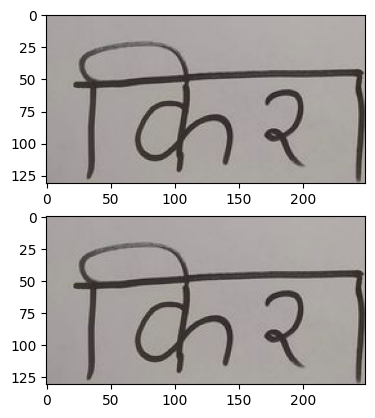

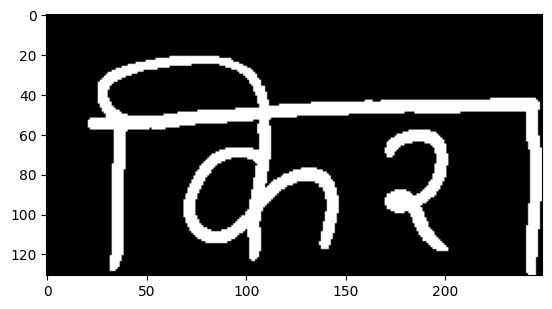

131
41727.27272727272
48 49


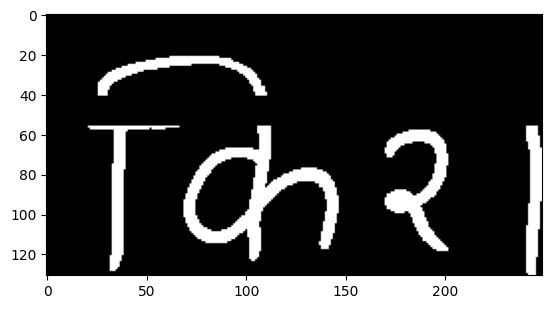

height 131 249
transitions [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 13, 13, 13, 11, 13, 13, 13, 11, 11, 11, 12, 12, 12, 12, 12, 14, 12, 12, 12, 12, 12, 12, 12, 12, 14, 12, 12, 12, 12, 12, 12, 10, 10, 10, 8, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 2, 2]
mewn 6.129770992366412
herr
2
herr
2
herr
4
herr
4
herr
4
herr
4
herr
4
herr
6
herr
6
herr
6
herr
6
herr
6
herr
8
vase 128
lower 128
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,

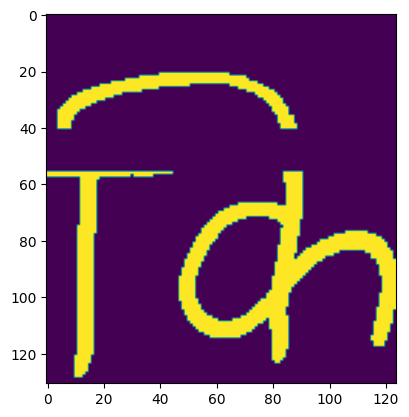

try
(131, 124)
(131, 124)
ss
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]
[21, 128]
vas 128
traile [21, 40, 56, 128]


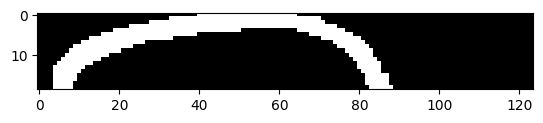

1/1 [==============================] - 1s 877ms/step
Upper Modifiers 0
0
pringpring
56 128
56 128
mnew
[2, 46]


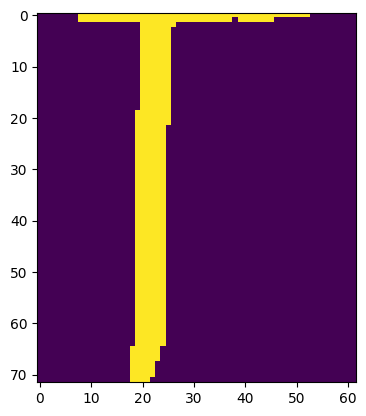

------------------------


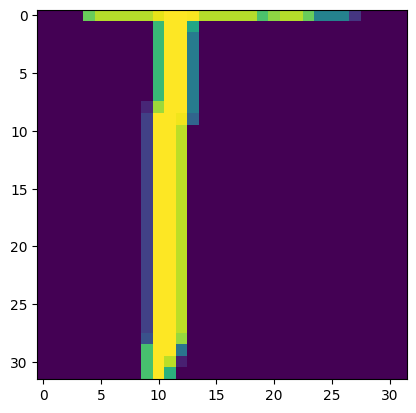

1/1 [==============================] - 0s 158ms/step
core Modifiers 68


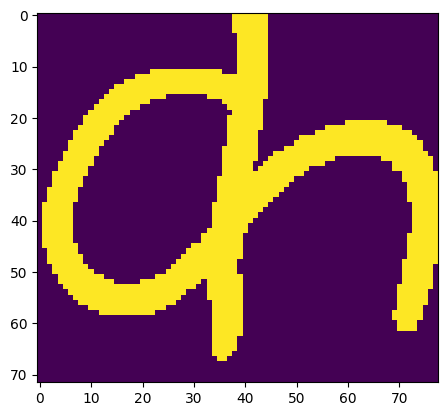

------------------------


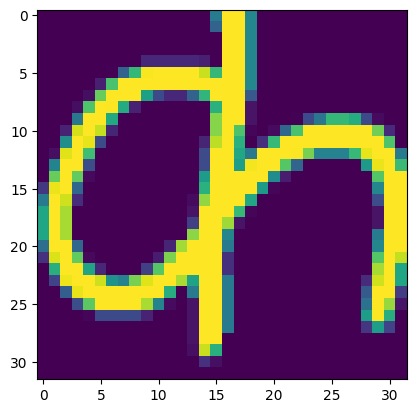

1/1 [==============================] - 0s 48ms/step
core Modifiers 42
leng of 2
core z 68
core 1 42
कि


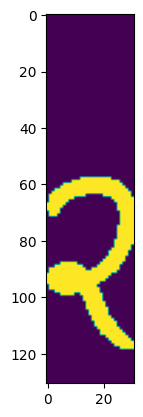

try
(131, 31)
(131, 31)
ss
[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
[58, 118]
vas 128
traile [58, 118]
10
pringpring
58 128
58 128


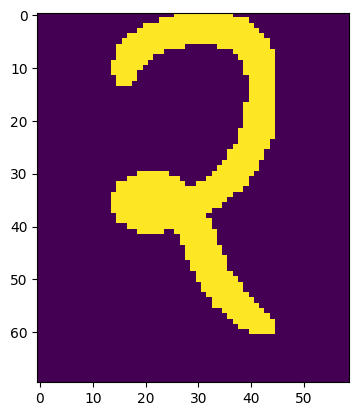

------------------------


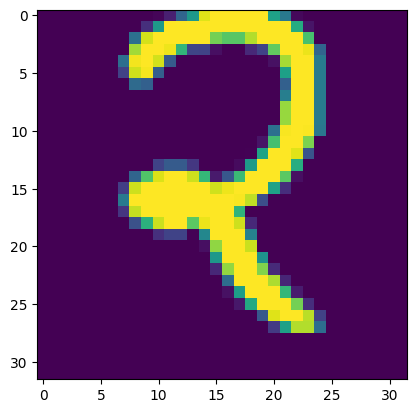

1/1 [==============================] - 0s 36ms/step
core Modifiers 26
leng of 1
र


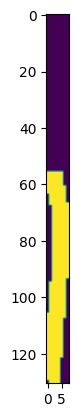

try
(131, 8)
(131, 8)
ss
[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
[56, 130]
vas 128
traile [56, 130]
10
pringpring
56 128
56 128


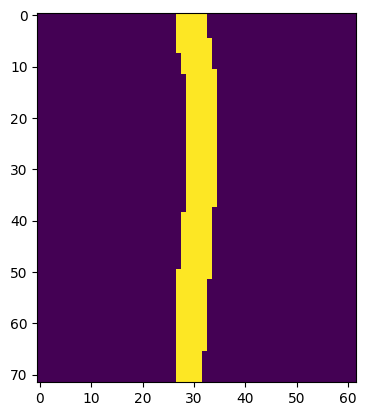

------------------------


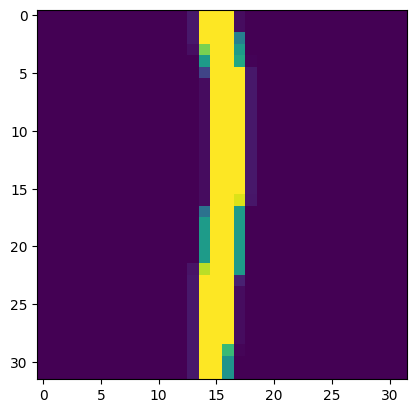

1/1 [==============================] - 0s 42ms/step
core Modifiers 68
leng of 1
ा
किरा


In [2]:
import numpy as np
import cv2
# import tensorflow as tf
import os

import Split_Words
import Split_Characters
import Predict_Characters

img = cv2.imread("kira.jpg")

Words = Split_Words.Split(img)
Split_Characters.Split(Words)


# Wait for a key press and close the window
cv2.waitKey(0)
cv2.destroyAllWindows()



In [1]:
from flask import Flask, request, jsonify
import werkzeug
import numpy as np
import cv2
import tensorflow as tf
import os
import cv2

import Split_Words
import Split_Characters
import Predict_Characters
app = Flask(__name__)

@app.route('/upload', methods=["POST"])
def upload():
    if(request.method == "POST"):
        imagefile = request.files['image']
        filename = werkzeug.utils.secure_filename(imagefile.filename)
        imagefile.save("./uploadedimages/" + filename)
        img = cv2.imread("./uploadedimages/" + filename)
        os.remove("./uploadedimages/" + filename)
        Words = Split_Words.Split(img)
        Characters = Split_Characters.Split(Words)
        Predictions = Predict_Characters.Predict(Characters)

        Words = []
        for Prediction in Predictions:
            Word = ''.join(Prediction)
            Words.append(Word)
        Words = ' '.join(Words)
        


        return jsonify({
            "message": Words
        })


if __name__ == "__main__":
    app.run(debug=True, port=4000)

2023-08-08 06:48:22.877793: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 06:48:23.214147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 06:48:23.215621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 06:48:24.751525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:4000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/xolo42/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/xolo42/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/home/xolo42/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/home/xolo42/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 678, in initialize
    self.init_sockets()
  File "/home/xolo42/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 317, in init_sockets
    self.s

SystemExit: 1

/home/xolo42/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
pip install flask

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 KB 306.8 kB/s eta 0:00:001m390.8 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 278.3 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 KB 36.8 kB/s eta 0:00:0031m50.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
